Four recipes for Hacking Statistics:
1. Direct Simulation
2. Shuffling
3. Boostraping
4. Cross Validation  

https://speakerdeck.com/jakevdp/statistics-for-hackers

# 1. Direct simulation

Problem: You toss a coin 30 times and see 22 heads. Is it a fair coin?  
Null hypothesis: The coin is fair.  

## Classic method: Binomial probability
Null hypothesis: The coin is fair.  
What is the probability of a fair coin showing 22 heads simply by chance?  
$$P(N_H,N_T) = {N \choose N_H}(p)^{N_H}(1-p)^{N_T}$$

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import factorial, floor, ceil
import pandas as pd
from sklearn.linear_model import LinearRegression
# sns.set()
plt.style.use('dark_background')

In [2]:
def pbinom(n, k, p):
    """
    n - number of trials
    k - number of sucesses
    p - expected probability of success
    """
    from scipy.special import comb
    return comb(n, k) * (p)**k * (1-p)**(n-k)

n = 30
nHeads = 22
pHead = 1/2

>The probability of exactly 22 heads is...

In [3]:
pbinom(n, nHeads, pHead)

0.0054509611800313

>...however, the right answer must consider the probability of a coin showing 22 OR MORE heads

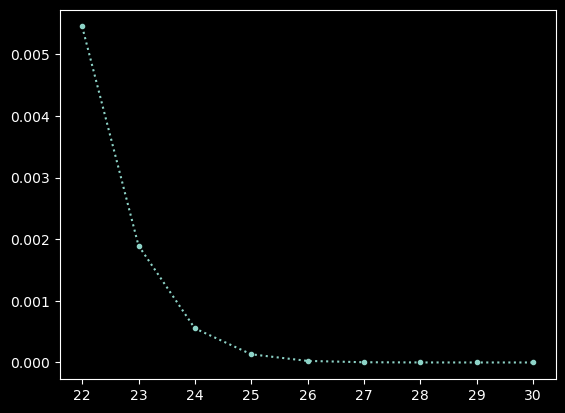

Sum of probabilities of 22 to 30 heads: 0.008062400855123997


In [4]:
probs = pbinom(30, np.arange(22,31), 1/2)
p = sum(probs)
plt.plot(range(22,31), probs, marker='.', linestyle=':'); plt.show()
print(f'Sum of probabilities of 22 to 30 heads: {p}')

**Plotting the probabilities from taking 30 to 0 heads from 30 trials:**

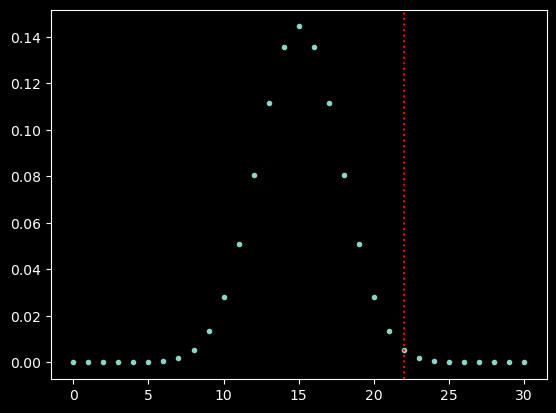

In [5]:
samples = np.arange(n+1)
probs = pbinom(30, 30-samples, pHead)
_ = plt.plot(samples, probs, marker='.', linestyle='none')
_ = plt.axvline(nHeads, linestyle='dotted', color='red')
_ = plt.annotate('{:.3f}'.format(sum(probs)), xy=(nHeads*1.01, sum(probs)), color='red')

In [6]:
print("Probability of %f for %d of %d observations showing heads given a fair coin." % (p, nHeads, n))
print('Reject the null Hypothesis that the coin is fair? %s' % (p < 0.05))

Probability of 0.008062 for 22 of 30 observations showing heads given a fair coin.
Reject the null Hypothesis that the coin is fair? True


## Alternative method: Direct simulation

In [7]:
# simulates 30 coin toss 10K times
nsim=10000
n=30 # coin toss
samples = np.random.randint(2, size=(nsim, n))
samples, samples.shape

(array([[1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 1],
        ...,
        [1, 1, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 1, 1, ..., 1, 0, 0]]),
 (10000, 30))

In [8]:
# computes probability of 22 heads
p = np.sum(samples.sum(axis = 1) >= nHeads) / nsim
p

0.0087

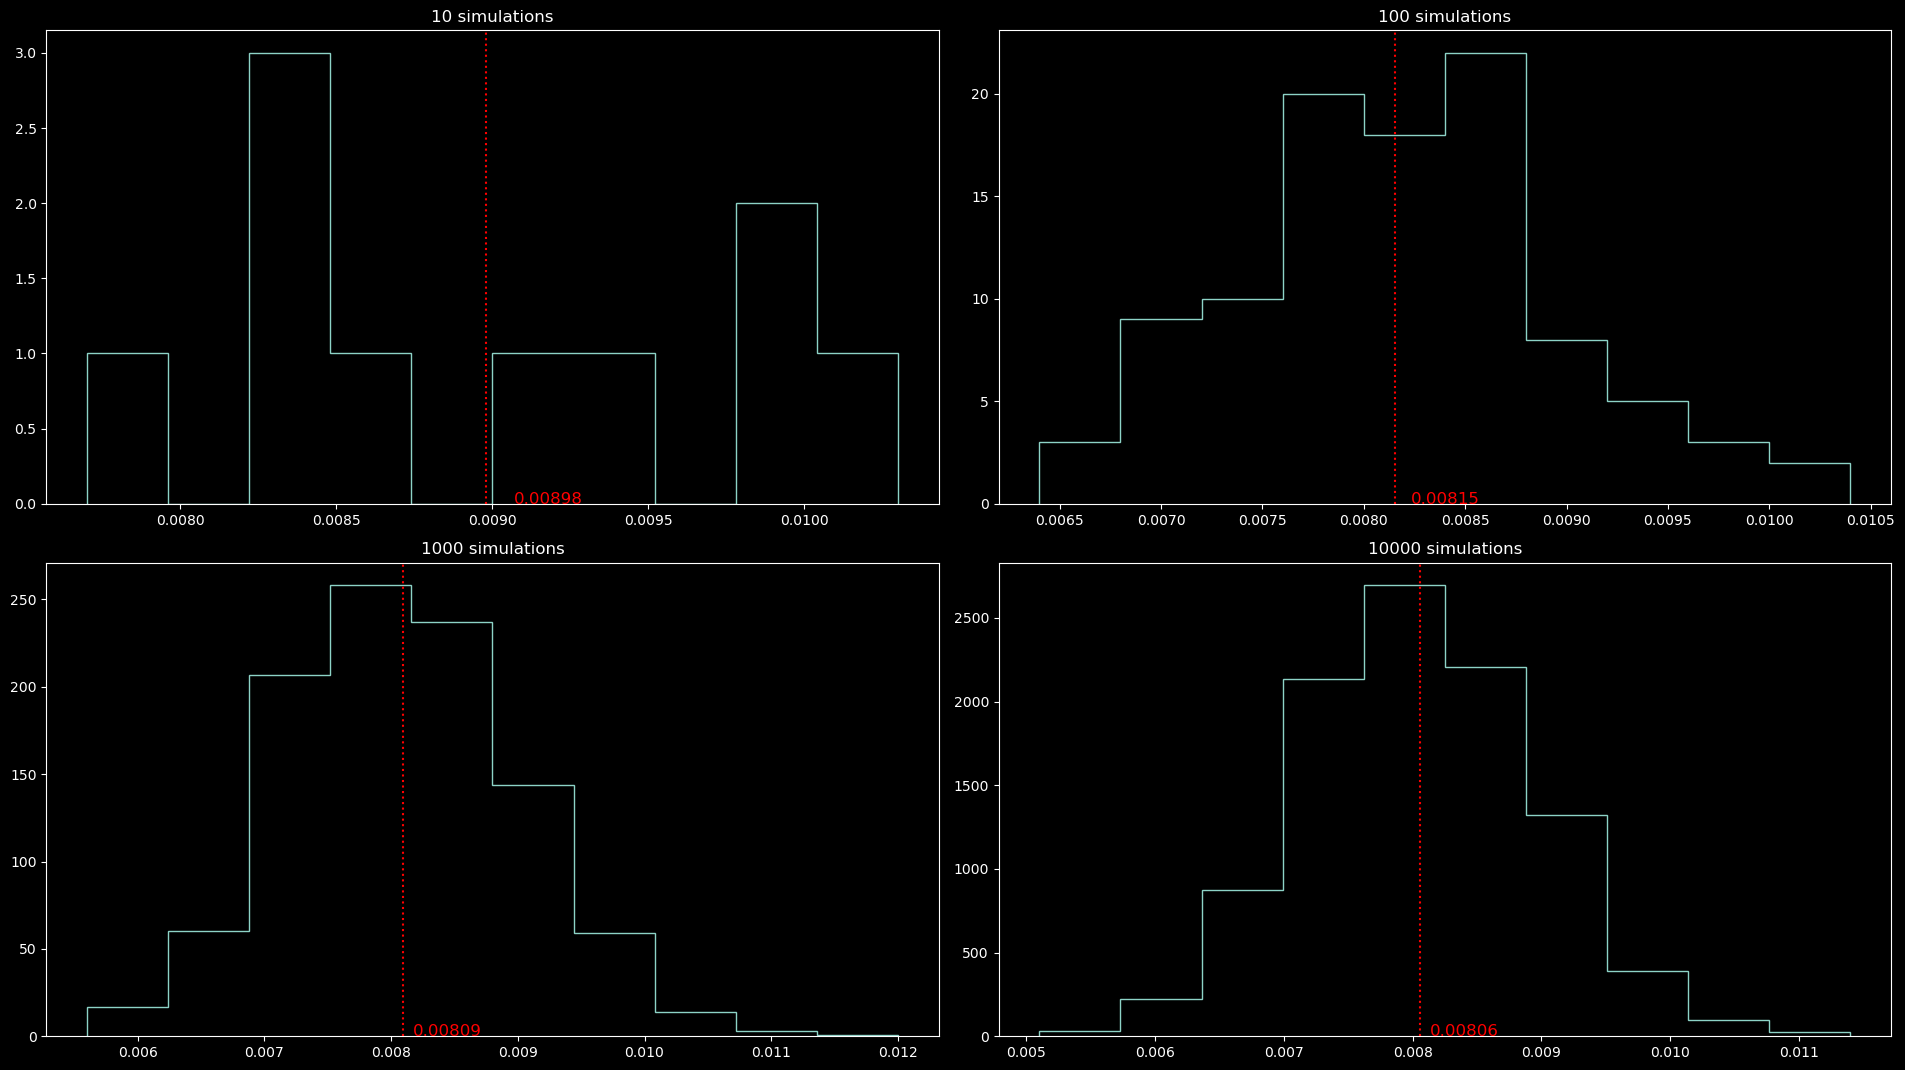

In [9]:
# repeating the simulation 10, 100, 1000 and 10000 times to check normality/robustness
plt.figure(figsize=(19.2, 10.8))
for i in range(4):
    probs = np.sum(np.random.randint(2, size=(10**(i+1), nsim, n)).sum(axis = 2) >= nHeads, axis = 1) / nsim
    plt.subplot(2,2,i+1)
    p = probs.mean()
    _ = plt.hist(probs, histtype='step')
    _ = plt.title('{:d} simulations'.format(10**(i+1)))
    _ = plt.axvline(p, linestyle='dotted', color='red')
    _ = plt.annotate('{:.5f}'.format(p), xy=(p*1.01, 0), color='red', size=12)

plt.tight_layout()

# 2. Shuffling

Problem: Mean difference between two groups (**Two-Sample T-test**)

Is this difference statistically significant?

Null hypothesis: The mean difference is not significant  

In [10]:
A = np.array([84, 72, 57, 46, 63, 76, 99, 91])
B = np.array([81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69])
print(f'A={A}\tmean={A.mean()}\tvar={A.var(ddof=1)}')

A=[84 72 57 46 63 76 99 91]	mean=73.5	var=316.2857142857143


In [11]:
print(f'B={B}\tmean={B.mean()}\tvar={B.var(ddof=1)}')

B=[81 69 74 61 56 87 69 65 66 44 62 69]	mean=66.91666666666667	var=124.81060606060606


In [12]:
diff = A.mean() - B.mean()
diff

6.583333333333329

## Classic method: Welch's t-test

t-Statistic  
$$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}}$$

In [13]:
t = (A.mean() - B.mean()) / np.sqrt(A.var(ddof=1)/len(A) + B.var(ddof=1)/len(B))
t

0.9316147771711583

Welch–Satterthwaite degrees of freedom equation  
$$ \nu = \frac{\left(\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}\right)^2}
             {\frac{(S_1^2/n_1)^2}{n_1-1}+\frac{(S_2^2/n_2)^2}{n_2-1}}$$

In [14]:
varA = A.var(ddof=1);
varB = B.var(ddof=1)
nA=len(A)
nB=len(B)
df = (varA/nA + varB/nB)**2 / ((varA/nA)**2/(nA-1) + (varB/nB)**2/(nB-1))
df

10.696428999751994

t-distribution probability density function

$\nu$ degrees of freedom
$$f(t) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu\pi}\Gamma\left(\frac{\nu}{2}\right)}   \left(1+\frac{t^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

Gamma function  
$$\Gamma(n)=(n-1)!$$

In [15]:
# TODO: still resulting different pvalue from statsmodels and scipy (ttest_ind)

adjust = lambda x: int(np.floor(x))

p = (
    ( factorial(adjust((df+1)/2)-1) /
     (np.sqrt(df * np.pi) * factorial(adjust(df/2)) ) ) * \
    ( (1+(t**2)/adjust(df)) ** (-adjust((df+1)/2)) )
)

In [16]:
print(f't-test statistic: {t}\np-value of the t-test: {p}\ndegrees of freedom used in the t-test: {df}')

t-test statistic: 0.9316147771711583
p-value of the t-test: 0.022756541912843178
degrees of freedom used in the t-test: 10.696428999751994


### t-test for independent samples

In [17]:
from statsmodels.stats.weightstats import ttest_ind
#t, p, dof = ttest_ind(A, B, alternative='smaller', usevar='unequal')
#t, p, dof = ttest_ind(A, B, alternative='larger', usevar='unequal')
t, p, dof = ttest_ind(A, B, alternative='two-sided', usevar='unequal')
print(f't-test statistic: {t}\np-value of the t-test: {p}\ndegrees of freedom used in the t-test: {dof}')

t-test statistic: 0.9316147771711583
p-value of the t-test: 0.3720857855465307
degrees of freedom used in the t-test: 10.696428999751992


In [18]:
from scipy import stats
# t, p, dof = 
result = stats.ttest_ind(A, B, equal_var=False)
t=result.statistic
p=result.pvalue
dof=result.df
print(f't-test statistic: {t}\np-value of the t-test: {p}\ndegrees of freedom used in the t-test: {dof}')

t-test statistic: 0.9316147771711583
p-value of the t-test: 0.3720857855465306
degrees of freedom used in the t-test: 10.696428999751994


In [19]:
print("Probability of %f for the mean difference (%f) is not significant" % (p, diff))
print('Reject the null Hypothesis that the mean the difference (%f) is not significant: %s' % (diff, p < 0.05))

Probability of 0.372086 for the mean difference (6.583333) is not significant
Reject the null Hypothesis that the mean the difference (6.583333) is not significant: False


## Alternative method: Shuffling
Simulate the distribution by shuffling the labels repeatedly and computing the desired statistc.

In [20]:
AB = np.concatenate((A, B), axis=0)

# function to calculate mean differences between two column slices
def split_mean_difference(x, a, b):
    return x[:a].mean() - x[a:a+b].mean()

# Shuffle resampling without repetition
nsims=10000
# np.argsort index trick to avoid replacement as np.choice needs to replace for 2 dimensional array generation
idx = np.argsort(np.random.randint(len(AB), size=(nsims, len(AB))), axis=1)
AB[idx]

array([[61, 62, 69, ..., 84, 65, 91],
       [69, 56, 72, ..., 91, 74, 69],
       [44, 65, 91, ..., 61, 87, 57],
       ...,
       [69, 72, 57, ..., 66, 81, 46],
       [69, 81, 65, ..., 61, 62, 69],
       [84, 91, 69, ..., 66, 76, 57]])

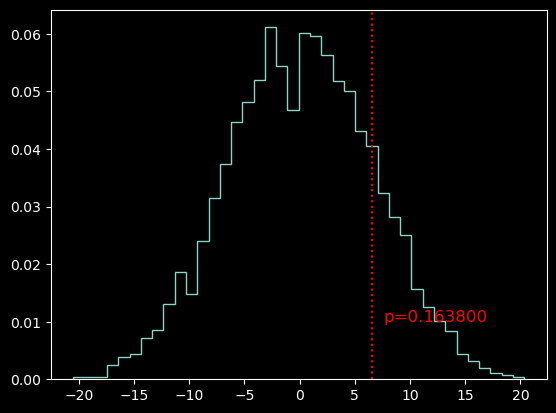

In [21]:
# computes 10000 means differences
shuffle_means = np.apply_along_axis(func1d=split_mean_difference, axis=1, arr=AB[idx],
                                    a=len(A), # 8
                                    b=len(B)) # 12

# computes probabilities in simulation
p = np.sum(shuffle_means > diff) / nsims

_ = plt.hist(shuffle_means, bins=40, density=True, histtype='step')
_ = plt.axvline(diff, linestyle='dotted', color='red')
_ = plt.annotate('p={:f}'.format(p), xy=(diff+1, 0.01), color='red', size=12)

In [22]:
print("Probability of %f for the mean difference (%f) is not significant" % (p, diff))
print('Reject the null Hypothesis that the mean the difference (%f) is not significant: %s' % (diff, p < 0.05))

Probability of 0.163800 for the mean difference (6.583333) is not significant
Reject the null Hypothesis that the mean the difference (6.583333) is not significant: False


# 3. Boostrap Resampling

In [23]:
x = np.array([48,24,32,61,51,12,32,18,19,24,21,41,29,21,25,23,42,18,23,13])
x

array([48, 24, 32, 61, 51, 12, 32, 18, 19, 24, 21, 41, 29, 21, 25, 23, 42,
       18, 23, 13])

## Classic method

Sample mean

In [24]:
xbar = x.mean()
xbar

28.85

Standard Error of the Mean
$$\frac{1}{\sqrt{N}}\sqrt{\frac{1}{N-1}\sum{(x_i-\bar{x})^2}}$$

In [25]:
SEM = 1 / np.sqrt(len(x)) * np.sqrt(1/(len(x)-1) * np.sum((x - xbar)**2))
SEM

2.9702693480558287

## Alternative method: boostrap resampling

In [26]:
# simulates 10K resample with repetitions
nsims=10000
resamples = np.random.choice(x, size=(nsims, len(x)))
# computes row mean and SEM (Standard Error of the Mean)
xbar = resamples.mean(axis=1) # 10000 means
xbarmean = xbar.mean() # mean of the means
SEM = xbar.std() # standard deviation of 10000 means
xbarmean, SEM

(28.895615000000003, 2.8986119129291867)

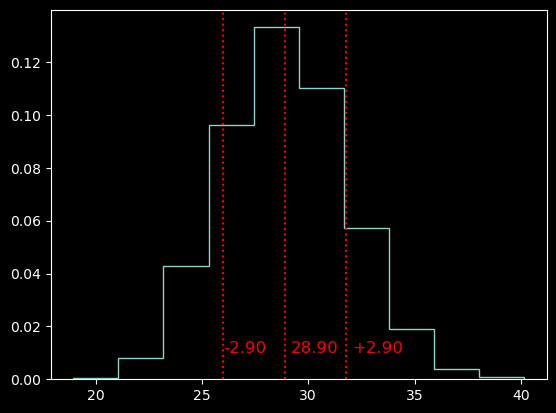

In [27]:
_ = plt.hist(xbar, density=True, histtype='step')

_ = plt.axvline(xbarmean-SEM, linestyle='dotted', color='red')
_ = plt.annotate('+{:2.2f}'.format(SEM), xy=(xbarmean*1.01+SEM, 0.01), color='red', size=12)

_ = plt.axvline(xbarmean, linestyle='dotted', color='red')
_ = plt.annotate('{:2.2f}'.format(xbarmean), xy=(xbarmean*1.01, 0.01), color='red', size=12)

_ = plt.axvline(xbarmean+SEM, linestyle='dotted', color='red')
_ = plt.annotate('-{:2.2f}'.format(SEM), xy=(xbarmean-SEM, 0.01), color='red', size=12)

## Bootstrap on linear regression

### Linear Regression example

In [28]:
# simulating m x 2 dataset: x, y
m=20
features = np.random.normal(size=m)
noise = np.random.normal(size=m)
samples = pd.DataFrame(np.column_stack((features, features + np.sin(noise))))
samples.columns = ['x', 'y']
slope, intercept = np.polyfit(samples.x, samples.y, deg=1)
"slopes", slope, "intercept", intercept

('slopes', 1.117262880876649, 'intercept', -0.07354171761973798)

Text(0.5, 0.98, 'Regression')

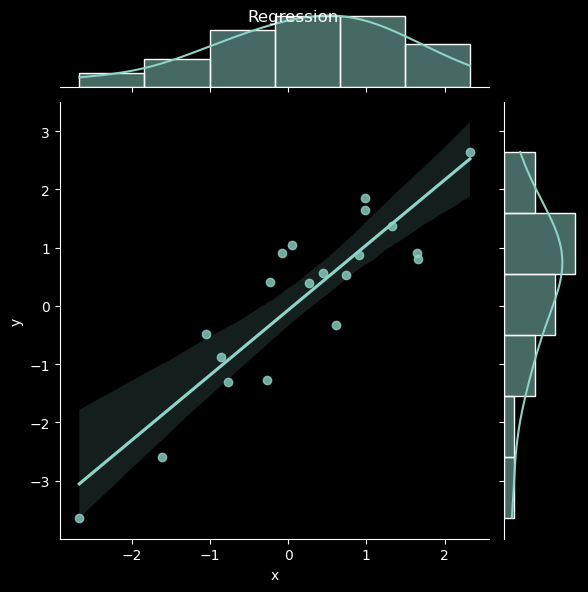

In [29]:
sns.jointplot(data=samples, x='x', y='y', kind='reg').fig.suptitle('Regression')

Text(0.5, 0.98, 'Regression')

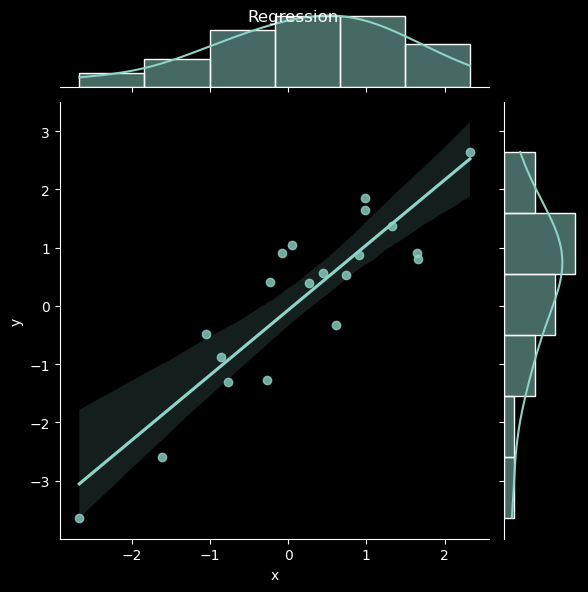

In [29]:
sns.jointplot(data=samples, x='x', y='y', kind='reg').fig.suptitle('Regression')

Text(0.5, 0.98, 'KDE')

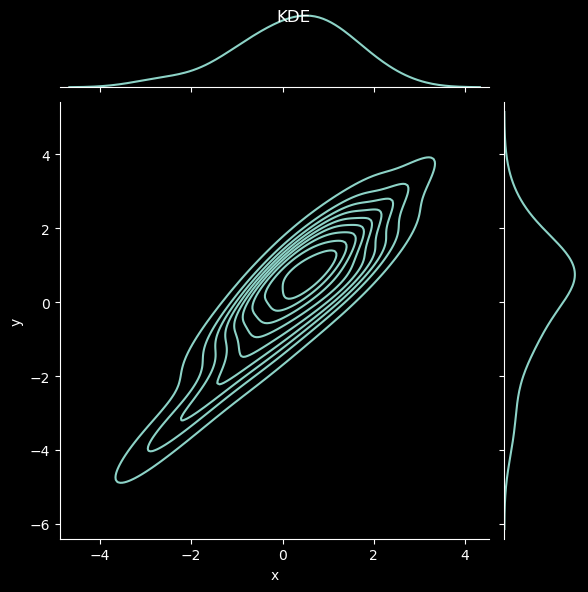

In [30]:
sns.jointplot(data=samples, x='x', y='y', kind='kde').fig.suptitle('KDE')

Regression residuals

You can optionally fit a lowess smoother to the residual plot, which can help in determining if there is structure to the residuals.

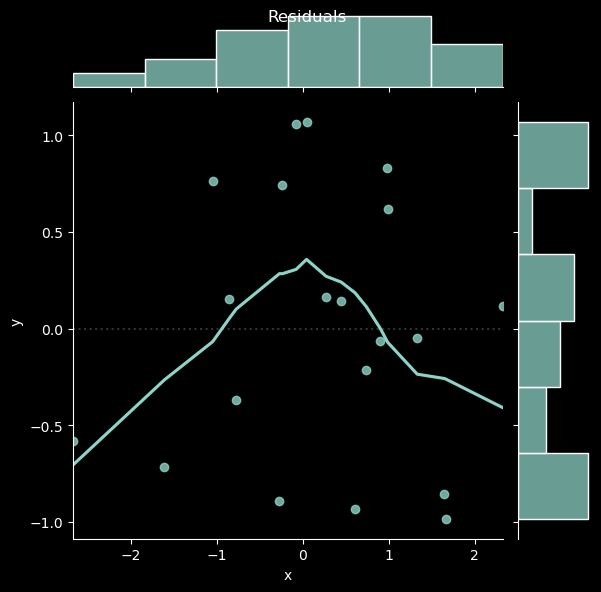

In [31]:
_ = sns.jointplot(data=samples, x='x', y='y', kind='resid', lowess=True).fig.suptitle('Residuals')

### Bootstraping Linear Regression

In [50]:
nsims=10000
#empty result data frame
results = pd.DataFrame(dtype='float64',index=range(nsims),columns=['slope', 'intercept'])
ids = samples.index.values
for sim in range(nsims):
    # resampling dataset rows with repetition
    bsIds = np.random.choice(ids, size=len(ids))
    # model fit with bootstrap resampling
    results.slope[sim], results.intercept[sim] = np.polyfit(samples.x[bsIds], y=samples.y[bsIds], deg=1)
results.mean()

slope        1.097267
intercept   -0.051632
dtype: float64

Text(0.5, 0.98, 'Regression')

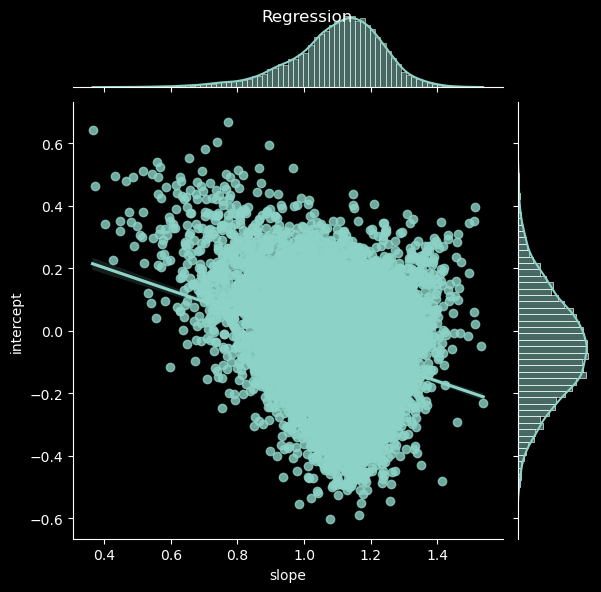

In [51]:
sns.jointplot(data=results, x='slope', y='intercept', kind='reg').fig.suptitle('Regression')

Text(0.5, 0.98, 'KDE')

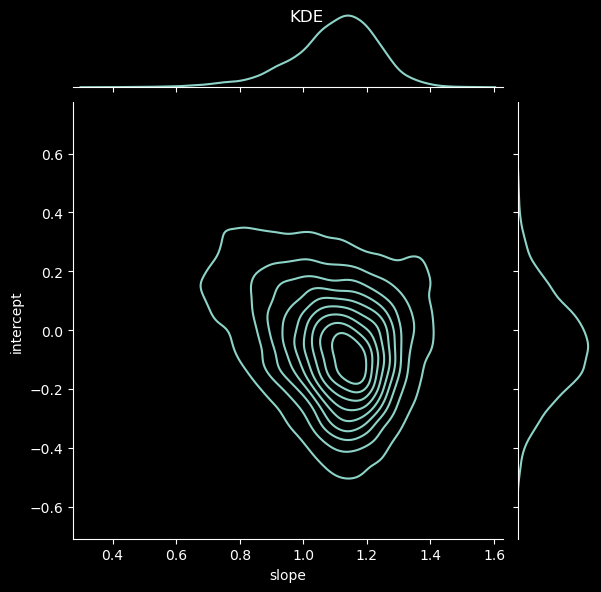

In [52]:
sns.jointplot(data=results, x='slope', y='intercept', kind='kde').fig.suptitle('KDE')

Text(0.5, 0.98, 'Residuals')

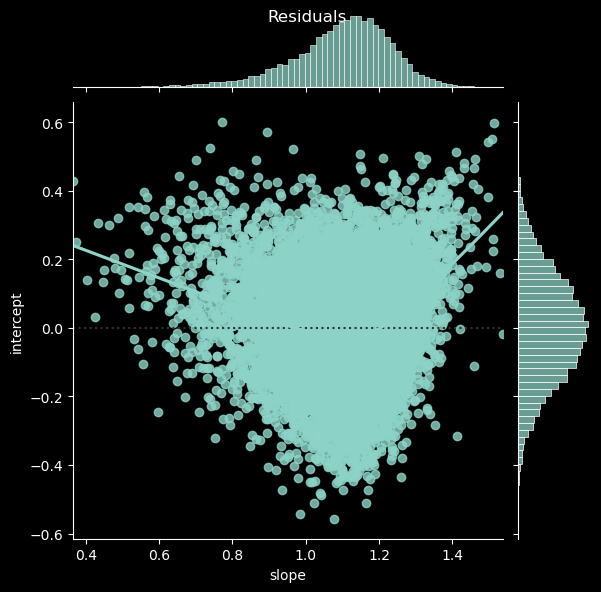

In [56]:
sns.jointplot(data=results, x='slope', y='intercept', kind='resid', lowess=True).fig.suptitle('Residuals')